# H2O AutoML 

This notebook applies H2O AutoML on energy usage prediction problem. H2O’s AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit.

* Check the link for more information on H2O AutoML [H2O AutoML documentation](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
print(h2o.__version__)
from h2o.automl import H2OAutoML

h2o.init(max_mem_size='16G')

3.34.0.1
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpwy6mr88m
  JVM stdout: /tmp/tmpwy6mr88m/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpwy6mr88m/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.1
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_rrwezj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [2]:
#upload the data 
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


It can be confirmed the dataset has two columns: datetime and consumed energy 

In [3]:
#check for missing values
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

There's no missing values in the data

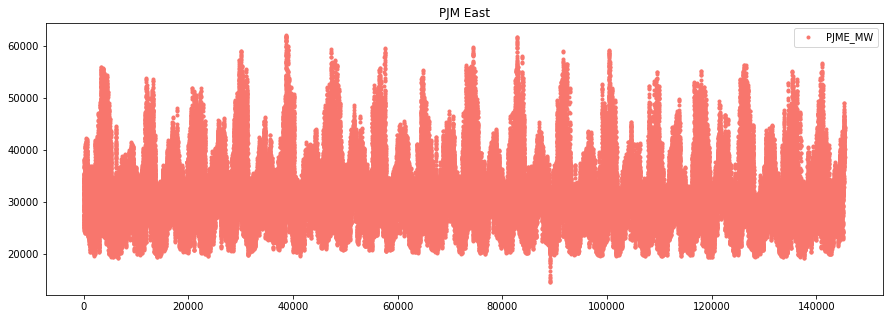

In [4]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

## Feature engineering

In [5]:
#add time based new features
df['date'] = pd.to_datetime(df['Datetime'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.weekday
df['weekend'] = df['weekday'].isin([5,6]).astype(int)

In [6]:
## cyclic transformation on hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/23.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/23.0)
## cyclic transformation on date 
df['date_sin'] = -np.sin(2 * np.pi * (df['month']+df['day']/31)/12)
df['date_cos'] = -np.cos(2 * np.pi * (df['month']+df['day']/31)/12)
## cyclic transformation on month
df['month_sin'] = -np.sin(2 * np.pi * df['month']/12.0)
df['month_cos'] = -np.cos(2 * np.pi * df['month']/12.0)
## cyclic transformation on weekday
df['weekday_sin'] = -np.sin(2 * np.pi * (df['weekday']+1)/7.0)
df['weekday_cos'] = -np.cos(2 * np.pi * (df['weekday']+1)/7.0)

In [7]:
df

,Datetime,PJME_MW,date,month,day,hour,weekday,weekend,hour_sin,hour_cos,date_sin,date_cos,month_sin,month_cos,weekday_sin,weekday_cos
0,2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,12,31,1,1,0,2.697968e-01,0.962917,-0.500000,-0.866025,2.449294e-16,-1.000000,-0.974928,0.222521
1,2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,12,31,2,1,0,5.195840e-01,0.854419,-0.500000,-0.866025,2.449294e-16,-1.000000,-0.974928,0.222521
2,2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,12,31,3,1,0,7.308360e-01,0.682553,-0.500000,-0.866025,2.449294e-16,-1.000000,-0.974928,0.222521
3,2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,12,31,4,1,0,8.878852e-01,0.460065,-0.500000,-0.866025,2.449294e-16,-1.000000,-0.974928,0.222521
4,2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,12,31,5,1,0,9.790841e-01,0.203456,-0.500000,-0.866025,2.449294e-16,-1.000000,-0.974928,0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145361,2018-01-01 20:00:00,44284.0,2018-01-01 20:00:00,1,1,20,0,0,-7.308360e-01,0.682553,-0.514555,-0.857457,-5.000000e-01,-0.866025,-0.781831,-0.623490
145362,2018-01-01 21:00:00,43751.0,2018-01-01 21:00:00,1,1,21,0,0,-5.195840e-01,0.854419,-0.514555,-0.857457,-5.000000e-01,-0.866025,-0.781831,-0.623490
145363,2018-01-01 22:00:00,42402.0,2018-01-01 22:00:00,1,1,22,0,0,-2.697968e-01,0.962917,-0.514555,-0.857457,-5.000000e-01,-0.866025,-0.781831,-0.623490
145364,2018-01-01 23:00:00,40164.0,2018-01-01 23:00:00,1,1,23,0,0,-2.449294e-16,1.000000,-0.514555,-0.857457,-5.000000e-01,-0.866025,-0.781831,-0.623490


In [8]:
#drop unnecessary columns 
df.drop(['Datetime', 'hour'], axis=1, inplace=True)

In [9]:
#Split the data into train and test. The last two months data is left for testing.
df_train = df[df['date'] <= '2017-10-30 00:00:00'].reset_index(drop=True)
df_test = df[df['date'] > '2017-10-30 00:00:00'].reset_index(drop=True)

In [10]:
#convert the data into h2o frame
train = h2o.H2OFrame(df_train)
test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
#set x and y
x = train.columns
y = 'PJME_MW'
x.remove(y)

Build H2OAutoML model and start training

In [12]:
aml = H2OAutoML(max_runtime_secs = 3500, seed = 1, project_name = "PJME_MW")
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_1_20211004_120027

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 74511.17538525061
RMSE: 272.9673522332856
MAE: 199.5868258612654
RMSLE: 0.008589749691822066
R^2: 0.9982387767431291
Mean Residual Deviance: 74511.17538525061
Null degrees of freedom: 9985
Residual degrees of freedom: 9982
Null deviance: 422627377773.8887
Residual deviance: 744068597.3971126
AIC: 140379.02250647917

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 426182.6895715847
RMSE: 652.8266918345057
MAE: 474.8457926644606
RMSLE: 0.02006849600647352
R^2: 0.9898712830720993
Mean Residual Deviance: 426182.6895715847
Null degrees of freedom: 138717
Residual degrees of freedom: 138714
Null deviance: 5836862131892.48

In [13]:
#extract the leaderboard 
lb = aml.leaderboard
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_3_AutoML_1_20211004_120027,426183,652.827,426183,474.846,0.0200685
StackedEnsemble_AllModels_4_AutoML_1_20211004_120027,426206,652.844,426206,474.854,0.020069
StackedEnsemble_AllModels_2_AutoML_1_20211004_120027,436998,661.058,436998,481.31,0.0203172
StackedEnsemble_AllModels_1_AutoML_1_20211004_120027,437016,661.072,437016,481.311,0.0203174
StackedEnsemble_BestOfFamily_3_AutoML_1_20211004_120027,459968,678.209,459968,494.322,0.0208203
StackedEnsemble_BestOfFamily_2_AutoML_1_20211004_120027,459971,678.212,459971,494.32,0.0208203
StackedEnsemble_BestOfFamily_1_AutoML_1_20211004_120027,464364,681.443,464364,496.655,0.0209198
XGBoost_1_AutoML_1_20211004_120027,466199,682.788,466199,497.901,0.0209805
XGBoost_2_AutoML_1_20211004_120027,643176,801.983,643176,596.879,0.0245864
XGBoost_grid_1_AutoML_1_20211004_120027_model_1,690743,831.11,690743,582.929,0.0256091


In [14]:
# The leader model is stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_1_20211004_120027

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 74511.17538525061
RMSE: 272.9673522332856
MAE: 199.5868258612654
RMSLE: 0.008589749691822066
R^2: 0.9982387767431291
Mean Residual Deviance: 74511.17538525061
Null degrees of freedom: 9985
Residual degrees of freedom: 9982
Null deviance: 422627377773.8887
Residual deviance: 744068597.3971126
AIC: 140379.02250647917

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 426182.6895715847
RMSE: 652.8266918345057
MAE: 474.8457926644606
RMSLE: 0.02006849600647352
R^2: 0.9898712830720993
Mean Residual Deviance: 426182.6895715847
Null degrees of freedom: 138717
Residual degrees of freedom: 138714
Null deviance: 5836862131892.482
Residual deviance: 59119210331.99109
AIC: 2191823.8212137874


## Prediction with the leader model

In [15]:
#prepare the test data
test_x = test.drop('PJME_MW', axis=1)

In [16]:
#make predictions on the test data
pred = aml.predict(test_x)
pred.head()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict
26773.2
24862.7
24836.6
24672.1
24783.3
25303.5
25703.5
25879.9
26870.2
27921.3


In [17]:
#make comparison df
result_comparison = test[['date', 'PJME_MW']]
result_comparison['predictions'] = pred
#convert h2o df into pandas df
result_comparison = h2o.as_list(result_comparison)
result_comparison["date"] = pd.to_datetime(result_comparison["date"],unit='ms')

In [18]:
result_comparison.head(20)

,date,PJME_MW,predictions
0,2017-12-31 01:00:00,35242,26773.232602
1,2017-12-31 02:00:00,34410,24862.690655
2,2017-12-31 03:00:00,34150,24836.608214
3,2017-12-31 04:00:00,34220,24672.140229
4,2017-12-31 05:00:00,34627,24783.275318
5,2017-12-31 06:00:00,35438,25303.494959
6,2017-12-31 07:00:00,36615,25703.451829
7,2017-12-31 08:00:00,37612,25879.924122
8,2017-12-31 09:00:00,38435,26870.155888
9,2017-12-31 10:00:00,38803,27921.280727


In [19]:
#save the leader model 
h2o.save_model(aml.leader, path = "./my_h2o_leader_model")

'/kaggle/working/my_h2o_leader_model/StackedEnsemble_AllModels_3_AutoML_1_20211004_120027'

## Thank you 